# dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaModel, BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torch import nn, optim
import numpy as np
from typing import Tuple, Dict, List
from tqdm.auto import tqdm
import timeit
import os
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tag import map_tag
from nltk.corpus import wordnet
import nltk
import joblib
import timeit
import re

In [2]:
df = pd.read_csv('C:\\Users\\Saeth\\Downloads\\NLP_kaggke_disaster_prediction\\train.csv')
#df = df.sample(frac=1).reset_index()
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [3]:
# null keywords count
df['keyword'].isna().sum() 

61

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [6]:
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

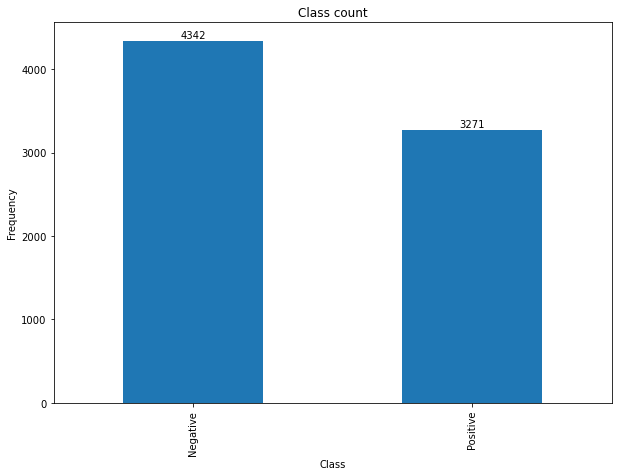

In [7]:
frequencies = list(df['target'].value_counts())
# In my original code I create a series and run on that,
# so for consistency I create a series from the list.
freq_series = pd.Series(frequencies)

x_labels = ['Negative','Positive']

# Plot the figure.
plt.figure(figsize=(10, 7))
ax = freq_series.plot(kind="bar")
ax.set_title("Class count")
ax.set_xlabel("Class")
ax.set_ylabel("Frequency")
ax.set_xticklabels(x_labels)

rects = ax.patches

# Make some labels.
labels = frequencies

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

plt.show()

# text preprocessing

In [8]:
# check duplicates
record = dict()
for i in range(len(df)):
    if df.iloc[i]['text'] not in record:
        record[df.iloc[i]['text']] = [[df.iloc[i]['target']], [i]]
    else:
        record[df.iloc[i]['text']][0].append(df.iloc[i]['target'])
        record[df.iloc[i]['text']][1].append(i)

In [9]:
recored_labels = [0,0,0,0,1,0,0,0,0,0] # correct label

In [10]:
track_index=-1
track_print = -1
drop_index = []
new_record = dict()
for text, [targets, indexs] in list(record.items()):
    track_index+=1
    if len(targets)>1:
        drop_index.extend(indexs[1:])
        count_0 = targets.count(0)
        count_1 = targets.count(1)
        if count_0>count_1:
            x=0
        elif count_1>count_0:
            x=1
        else:
            track_print+=1
            print(text)
            print(targets)
            #x = input('the right label: ')
            x = recored_labels[track_print]
            print('the right label: ', x)
        #print(indexs)
        #print(drop_index)
        for i in range(len(df)):
            if df.iloc[i]['text']==text:
                df.at[i, 'target'] = x
        if track_print==20:
            print('track_index', track_index)
            break

To fight bioterrorism sir.
[1, 0, 1, 0]
the right label:  0
Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...
[1, 0]
the right label:  0
I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????
[0, 1]
the right label:  0
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit
[1, 0]
the right label:  0
Caution: breathing may be hazardous to your health.
[1, 0]
the right label:  1
Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!
[0, 1]
the right label:  0
RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG
[0, 1]
the right label:  0
wowo--=== 12000 Nigerian refugees repatriated from Cameroon
[1, 0]
the right label:  0
that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time
[1, 0

In [11]:
track_index

7502

In [12]:
# drop duplicates
df = df.drop(df.index[drop_index])

In [13]:
remove_stop_initial = False
def text_preprocess(text, remove_stop = False):
    # delete a whole word with: http, #, @, numbers
    out = text.lower().split(' ')
    for i in range(len(out)):
        #print(out[i])
        if 'http' in out[i]: # delete http
            out[i] = ''
        if '#' in out[i]: # delete http
            out[i] = ''
        if '@' in out[i]: # delete http
            out[i] = ''
        if len(re.findall('[1-9]', out[i]))!=0:
            out[i] = ''
    # replace all non a-z with ' '
    text = ' '.join(out)
    text = re.sub('[^a-z]', ' ', text)
    out = text.lower().split(' ')
    out = [i.strip() for i in out if len(i)>0]
    #out = [i for i in simple_preprocess(' '.join(out), min_len=1)]
    #out = [i for i in simple_preprocess(' '.join(out), min_len=1) if i.strip() in valid_words]
    if remove_stop == True:
        out = [i for i in out if i not in STOPWORDS]
    return ' '.join(out)

In [14]:
sentence = df.iloc[1]['text']
print(sentence)
text_preprocess(sentence, remove_stop = remove_stop_initial)

Forest fire near La Ronge Sask. Canada


'forest fire near la ronge sask canada'

In [15]:
text_preprocess(sentence, remove_stop = True)

'forest near la ronge sask canada'

In [16]:
start = timeit.default_timer()
df['text'] = df['text'].apply(lambda x: text_preprocess(x, remove_stop = remove_stop_initial))
stop = timeit.default_timer()
print('time load freq_dict (Sec): ', stop-start)
df

time load freq_dict (Sec):  0.1607440000000011


,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this may allah for...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,people receive evacuation orders in california,1
4,7,NaN,NaN,just got sent this photo from ruby as smoke fr...,1
...,...,...,...,...,...
7604,10863,NaN,NaN,fallen powerlines on g link tram update fire c...,1
7605,10864,NaN,NaN,on the flip side i m at walmart and there is a...,1
7606,10866,NaN,NaN,suicide bomber kills in saudi security site mo...,1
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,1


# train-test split

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [19]:
# apply text tokenizer
tokenized=df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized

0       [101, 2256, 15616, 2024, 1996, 3114, 1997, 202...
1       [101, 3224, 2543, 2379, 2474, 6902, 3351, 2187...
2       [101, 2035, 3901, 2356, 2000, 7713, 1999, 2173...
3         [101, 2111, 4374, 13982, 4449, 1999, 2662, 102]
4       [101, 2074, 2288, 2741, 2023, 6302, 2013, 1009...
                              ...                        
7604    [101, 5357, 2373, 12735, 2006, 1043, 4957, 125...
7605    [101, 2006, 1996, 11238, 2217, 1045, 1049, 201...
7606    [101, 5920, 9472, 8563, 1999, 8174, 3036, 2609...
7608    [101, 2048, 5016, 27083, 3173, 1037, 2958, 785...
7612    [101, 1996, 6745, 2062, 5014, 10958, 5422, 201...
Name: text, Length: 7503, dtype: object

In [20]:
# max len tokenized
max_len = max(len(i) for i in tokenized)
max_len

41

In [21]:
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [22]:
padded.shape

(7503, 41)

In [23]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(7503, 41)

In [24]:
labels = np.array(df['target'])
labels.shape

(7503,)

In [25]:
# train-test split
train_size = int(len(attention_mask)*0.75)
padded_train = padded[:train_size]
padded_val = padded[train_size:]
attention_mask_train = attention_mask[:train_size]
attention_mask_val = attention_mask[train_size:]
labels_train = labels[:train_size]
labels_val = labels[train_size:]
len(padded_train), len(padded_val), len(attention_mask_train), len(attention_mask_val)

(5627, 1876, 5627, 1876)

In [26]:
len(labels_train), len(labels_val)

(5627, 1876)

In [27]:
# custom dataset
class TokenDataset(Dataset):
    def __init__(self,padded, attention_mask, labels):
        self.padded = padded # array
        self.attention_mask = attention_mask # array
        self.labels = labels # aray
        
    def __len__(self):
        return len(self.padded)

    def __getitem__(self, index: int):
        token_id = torch.from_numpy(self.padded[index]).int()
        attention = torch.from_numpy(self.attention_mask[index]).int()
        label = torch.from_numpy(np.array(self.labels[index]))
        return  token_id, attention, label

In [28]:
train_dataset = TokenDataset(padded_train, attention_mask_train, labels_train)
val_dataset = TokenDataset(padded_val, attention_mask_val, labels_val)

batch_size = 32
num_worker = 0
#num_worker = os.cpu_count()
train_dataloader = DataLoader(train_dataset,batch_size, num_workers=num_worker, shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size, num_workers=num_worker, shuffle=True)

# model

In [29]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [30]:
class SentimentClassifier2(nn.Module):

  def __init__(self, n_classes, hidden_lstm):
    super().__init__()
    self.bert = BertModel.from_pretrained("bert-large-uncased")
    self.biLstms = nn.LSTM(input_size = 1, 
                         hidden_size =hidden_lstm,
                         num_layers = 2,
                         batch_first =True,
                         bidirectional =True)
    self.lstms = nn.LSTM(input_size = 2*hidden_lstm, 
                         hidden_size =hidden_lstm,
                         num_layers = 4,
                         batch_first =True)
    self.linear1 = nn.Linear(hidden_lstm*self.bert.config.hidden_size, 128)
    self.linear2 = nn.Linear(128, 48)
    self.linear3 = nn.Linear(48, n_classes)
    self.relu = nn.ReLU()
    self.hidden_lstm = hidden_lstm
  
  def forward(self, input_ids, attention_mask):
    last_hidden_states = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    ) # out = [batch, seq_len, hidden units = 768]
    batch, seq_length, hidden_units = last_hidden_states[0].shape
    out = last_hidden_states[0][:, 0, :] # shape = [batch, hidden units], [CLS] extraction
    out, (h,c) = self.biLstms(out.reshape(batch, hidden_units, 1)) # out = [batch, seq_length = 768, 2xhidden_lstm]
    out, (h,c) = self.lstms(out, (h,c)) # out = [batch, seq_len = 768, hidden_lstm]
    out = self.relu(self.linear1(out.reshape(batch, hidden_units*self.hidden_lstm)))
    out = self.relu(self.linear2(out))
    out = self.linear3(out)
    return out

In [31]:
class SentimentClassifier1(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained("bert-base-uncased")
    self.classifyer = nn.Linear(self.bert.config.hidden_size, n_classes)
                                    
    #self.linear1 = nn.Linear(self.bert.config.hidden_size, 256)
    #self.linear2 = nn.Linear(256, n_classes)
    #self.relu = nn.ReLU()
    #self.drop = nn.Dropout(p=0.15)
    #self.layerNorm = nn.LayerNorm(self.bert.config.hidden_size)
  
  def forward(self, input_ids, attention_mask):
    last_hidden_states = self.bert(input_ids=input_ids,
      attention_mask=attention_mask) # out = [batch, seq_len, hidden units]
    #out = self.layerNorm(last_hidden_states[0])[:, 0, :] # shape = [batch, hidden units]
    #out = self.drop(self.relu(self.linear1(out)))
    #out = self.linear2(out)
    out = last_hidden_states[0][:, 0, :] # shape = [batch, hidden units]
    #out = last_hidden_states[1] # shape = [batch, hidden units]
    out = self.classifyer(out)
    return out

In [32]:
class SentimentClassifier0(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained("bert-large-uncased")
    self.drop = nn.Dropout(p=0.2)
    self.linear = nn.Sequential(nn.Linear(self.bert.config.hidden_size, 512),
                                nn.Linear(512, 256),
                                nn.Linear(256, 128),
                                nn.Linear(128, 64),
                                nn.Linear(64, 32),
                                nn.Linear(32, 16),
                                nn.Linear(16, 8))
    self.last = nn.Linear(8, n_classes)

  
  def forward(self, input_ids, attention_mask):
    last_hidden_states = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    ) # out = [batch, seq_len, hidden units]
    out = last_hidden_states[0][:, 0, :] # shape = [batch, hidden units]
    out = self.drop(self.linear(out))
    out = self.last(out)
    return out

In [33]:
set_seeds()
#model = SentimentClassifier2(n_classes = 1, hidden_lstm=100).to(device)
#model = BertModel.from_pretrained("bert-base-uncased").to(device)
model = SentimentClassifier1(n_classes = 1).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [45]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, sample in enumerate(dataloader):
        # Send data to target device
        token_id, mask, labels = sample
        batch_size, seq_len = token_id.shape # labels size = [batch]
        token_id = token_id.to(device)
        mask = mask.to(device)
        labels = labels.to(device)

        # 1. Forward pass
        y_pred = model(token_id, mask).squeeze() # size = [batch, num_class]
        y_pred_class = torch.round(torch.sigmoid(y_pred)) # size = [batch]

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, labels.float())
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        
        train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

        # Calculate and accumulate accuracy metric across all batches
        #delta_y = y.detach().cpu().numpy() - y_pred.detach().cpu().numpy()
        #train_acc+= (np.sum((y.detach().cpu().numpy()-delta_y)/y.detach().cpu().numpy())/len(y))*100
        #print(batch, loss.item(), train_acc/(batch+1))

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device):
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, sample in enumerate(dataloader):
            # Send data to target device
            token_id, mask, labels = sample
            batch_size, seq_len = token_id.shape # labels size = [batch]
            token_id = token_id.to(device)
            mask = mask.to(device)
            labels = labels.to(device)
            

            # 1. Forward pass
            test_pred_logits = model(token_id, mask).squeeze() # size = [batch, num_class]

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, labels.float())
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            #delta_y = y.detach().cpu().numpy() - test_pred_logits.detach().cpu().numpy()
            #test_acc+= (np.sum((y.detach().cpu().numpy()-delta_y)/y.detach().cpu().numpy())/len(y))*100
            y_pred_class = torch.round(torch.sigmoid(test_pred_logits)) # size = [batch]
            test_acc += (y_pred_class == labels).sum().item()/len(test_pred_logits)

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    
    # track accuracy (if it doesn't increase, reducr the learning rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)
    
    early_stop_count=0
    
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        start = timeit.default_timer()
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        print('train', epoch+1, 'completed')
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
        print('test', epoch+1, 'completed')
        stop = timeit.default_timer()

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"time (sec): {stop-start:.2f}"
        )
        
        scheduler.step(test_acc) # monitor test accuracy
        
        # early stopping
        if epoch==0:
            pass
        else:
            if  test_acc-results["test_acc"][-1] <= 0.001:
                early_stop_count+=1
                if early_stop_count==5:
                    print('early stopping!')
                    break
            else:
                early_stop_count=0
        
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
                
    # Return the filled results at the end of the epochs
    return results

In [41]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(1, len(results["train_loss"])+1)

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.xticks(epochs)
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.xticks(epochs)
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    print('average train accuracy:', sum(accuracy)/len(accuracy))
    print('average test accuracy:', sum(test_accuracy)/len(test_accuracy))

In [42]:
def plot_confision_matrix(model, dataloader, num_classes):
    # 1. Make predictions with trained model
    y_preds = []
    y_trues = []
    model.eval()
    with torch.inference_mode():
         for batch, sample in enumerate(dataloader):
            # Send data to target device
            token_id, mask, labels = sample
            batch_size, seq_len = token_id.shape # labels size = [batch]
            token_id = token_id.to(device)
            mask = mask.to(device)
            labels = labels.to(device)
            

            # 1. Forward pass
            y_pred_class = torch.round(torch.sigmoid(model(token_id, mask).squeeze())) # size = [batch]
            y_preds.append(y_pred_class.cpu())
            y_trues.append(labels.cpu())
    # Concatenate list of predictions into a tensor
    y_pred_tensor = torch.cat(y_preds)
    y_true_tensor = torch.cat(y_trues)
    
    # 2. Setup confusion matrix instance and compare predictions to targets
    confmat = ConfusionMatrix(num_classes=num_classes)
    confmat_tensor = confmat(preds=y_pred_tensor,
                             target=y_true_tensor)

    # 3. Plot the confusion matrix
    class_dict = {0: 'Negative',
                  1: 'Positive'}
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
        colorbar=True,
        show_absolute=True,
        show_normed=True,
        class_names=class_dict.values(),
        figsize=(10, 7)
    );

In [56]:
def predict(model, test_df):
    y_preds = []
    test_df['text'] = test_df['text'].apply(lambda x: text_preprocess(x, remove_stop = remove_stop_initial))
    tokenized=test_df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    max_len = max(len(i) for i in tokenized)
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)
    model.eval()
    with torch.inference_mode():
         for sample_index in tqdm(range(len(padded))):
            # Send data to target device
            token_id = torch.from_numpy(padded[sample_index].reshape(1, max_len)).int().to(device)
            mask = torch.from_numpy(attention_mask[sample_index].reshape(1, max_len)).int().to(device)
            
            # 1. Forward pass
            y_pred_class = torch.round(torch.sigmoid(model(token_id, mask).squeeze())) # size = [batch]
            y_preds.append(int(y_pred_class.cpu().item()))
    # Concatenate list of predictions into a tensor
    return y_preds

# train

In [46]:
linear_list = [model.classifyer.parameters(),
              model.bert.encoder.layer[11].parameters()] # layer 11 or 23

In [47]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.parameters():
    param.requires_grad = False
    
for unfreeze in linear_list:
    for param in unfreeze:
        param.requires_grad = True
    # Define loss and optimizer
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    results = train(model=model,
                           train_dataloader=train_dataloader,
                           test_dataloader=val_dataloader,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=20,
                           device=device)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]
    
    print('average train accuracy:', sum(accuracy)/len(accuracy))
    print('average test accuracy:', sum(test_accuracy)/len(test_accuracy))
    # Plot the loss curves of our model
    #plot_loss_curves(results)
    # plot confusion matrix
    #plot_confision_matrix(model, val_dataloader, 2)

  0%|          | 0/20 [00:00<?, ?it/s]

train 1 completed
test 1 completed
Epoch: 1 | train_loss: 0.5596 | train_acc: 0.7314 | test_loss: 0.4926 | test_acc: 0.7761 | time (sec): 43.91
train 2 completed
test 2 completed
Epoch: 2 | train_loss: 0.4970 | train_acc: 0.7739 | test_loss: 0.4643 | test_acc: 0.7832 | time (sec): 43.89
train 3 completed
test 3 completed
Epoch: 3 | train_loss: 0.4855 | train_acc: 0.7795 | test_loss: 0.4533 | test_acc: 0.7872 | time (sec): 43.86
train 4 completed
test 4 completed
Epoch: 4 | train_loss: 0.4711 | train_acc: 0.7840 | test_loss: 0.4491 | test_acc: 0.7882 | time (sec): 43.90
train 5 completed
test 5 completed
Epoch: 5 | train_loss: 0.4629 | train_acc: 0.7900 | test_loss: 0.4449 | test_acc: 0.8103 | time (sec): 43.90
train 6 completed
test 6 completed
Epoch: 6 | train_loss: 0.4591 | train_acc: 0.7959 | test_loss: 0.4403 | test_acc: 0.7914 | time (sec): 43.93
train 7 completed
test 7 completed
Epoch: 7 | train_loss: 0.4584 | train_acc: 0.8006 | test_loss: 0.4363 | test_acc: 0.8071 | time (sec)

  0%|          | 0/20 [00:00<?, ?it/s]

train 1 completed
test 1 completed
Epoch: 1 | train_loss: 0.4907 | train_acc: 0.7877 | test_loss: 0.4247 | test_acc: 0.8186 | time (sec): 47.46
train 2 completed
test 2 completed
Epoch: 2 | train_loss: 0.4269 | train_acc: 0.8129 | test_loss: 0.4134 | test_acc: 0.8282 | time (sec): 47.44
train 3 completed
test 3 completed
Epoch: 3 | train_loss: 0.4100 | train_acc: 0.8242 | test_loss: 0.4171 | test_acc: 0.8160 | time (sec): 47.41
train 4 completed
test 4 completed
Epoch: 4 | train_loss: 0.3922 | train_acc: 0.8322 | test_loss: 0.5051 | test_acc: 0.8229 | time (sec): 47.39
train 5 completed
test 5 completed
Epoch: 5 | train_loss: 0.3741 | train_acc: 0.8337 | test_loss: 0.4198 | test_acc: 0.8229 | time (sec): 47.40
train 6 completed
test 6 completed
Epoch: 6 | train_loss: 0.3570 | train_acc: 0.8460 | test_loss: 0.4407 | test_acc: 0.8164 | time (sec): 47.42
train 7 completed
test 7 completed
Epoch: 7 | train_loss: 0.3660 | train_acc: 0.8426 | test_loss: 0.4398 | test_acc: 0.8237 | time (sec)

average train accuracy: 0.8629343565867001
average test accuracy: 0.8179925847457629


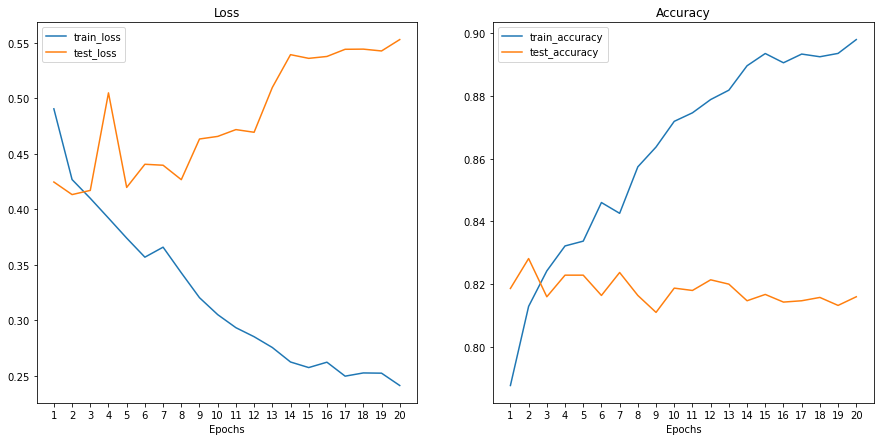

In [48]:
plot_loss_curves(results)

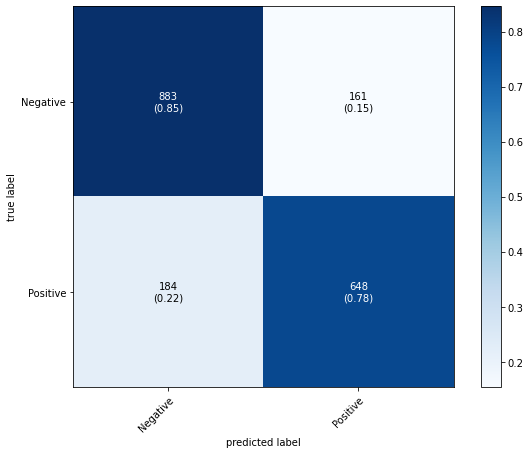

In [49]:
plot_confision_matrix(model, val_dataloader, 2)

# submission

In [57]:
test_df = pd.read_csv('C:\\Users\\Saeth\\Downloads\\NLP_kaggke_disaster_prediction\\test.csv')
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [58]:
predictions = predict(model, test_df)

  0%|          | 0/3263 [00:00<?, ?it/s]

In [59]:
predictions[:10]

[1, 1, 1, 0, 1, 1, 0, 0, 0, 0]

In [60]:
submission = pd.read_csv('C:\\Users\\Saeth\\Downloads\\NLP_kaggke_disaster_prediction\\sample_submission.csv')

In [61]:
submission['target'] = pd.Series(predictions)

In [62]:
submission.to_csv("C:\\Users\\Saeth\\Downloads\\NLP_kaggke_disaster_prediction\\kaggle_submission_v2.csv", index=False)